# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "CF"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'CF',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups                     
Sample_123  A6NCE7;H3BTL1;Q9GZQ8                  14.846
Sample_033  J3QQR8;J3QQX6;J3QRQ1;J3QRT5;P13598    16.543
Sample_081  Q6UWP8                                13.840
Sample_056  A0A0A0MT26;P13637;P13637-2;P13637-3   16.857
Sample_043  A0A087X0S5;P12109                     20.485
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by CF: runs/alzheimer_study/preds/pred_real_na_CF.csv


Sample ID   protein groups      
Sample_177  P22004                 13.261
Sample_046  Q9Y240                 16.520
Sample_026  H3BRQ4;K4DIB9;P50238   12.826
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 14.105
            A0A075B6Q5                 12.743
            A0A075B6R2                 12.422
            A0A075B6S5                 13.409
            A0A087WSY4                 11.970
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   13.610
            Q9UI40;Q9UI40-2            12.244
            Q9UIW2                     12.841
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   11.255
            Q9UP79                     11.590
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.371,15.050,16.842,19.863,16.520,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.888,19.067,...,15.528,15.576,14.907,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.978,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,14.534,17.705,17.039,15.953,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.100,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,15.063,15.345,17.084,18.708,14.249,19.433,11.788,11.243
Sample_207,15.739,16.877,15.469,16.898,14.717,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,13.096,12.728,13.566,13.162,11.806,13.089,12.316,12.934,13.095,11.869
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,14.425,19.067,16.127,...,12.328,11.572,12.424,13.374,12.050,13.234,13.678,13.456,12.619,12.914
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,12.989,12.488,12.456,12.191,13.132,13.090,12.582,13.717,12.256,12.456
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,12.519,12.949,12.984,12.647,12.000,13.037,12.352,11.915,13.489,12.117
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,11.243,11.658,13.443,11.202,13.495,13.090,12.489,13.217,12.131,12.336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.076,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 249.85it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  7.87it/s]

100%|██████████| 2/2 [00:00<00:00,  7.81it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  8.54it/s]

100%|██████████| 3/3 [00:00<00:00,  6.11it/s]

100%|██████████| 3/3 [00:00<00:00,  6.45it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.11it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.63it/s]

100%|██████████| 4/4 [00:00<00:00,  4.71it/s]

100%|██████████| 4/4 [00:00<00:00,  5.11it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  7.24it/s]

 60%|██████    | 3/5 [00:00<00:00,  5.08it/s]

 80%|████████  | 4/5 [00:00<00:00,  4.45it/s]

100%|██████████| 5/5 [00:01<00:00,  4.21it/s]

100%|██████████| 5/5 [00:01<00:00,  4.59it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  7.98it/s]

 50%|█████     | 3/6 [00:00<00:00,  5.59it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.53it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  4.48it/s]

100%|██████████| 6/6 [00:01<00:00,  4.39it/s]

100%|██████████| 6/6 [00:01<00:00,  4.76it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  6.30it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.93it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.30it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  4.11it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.86it/s]

100%|██████████| 7/7 [00:01<00:00,  3.92it/s]

100%|██████████| 7/7 [00:01<00:00,  4.20it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  6.90it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.83it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.11it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  4.06it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.99it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  4.11it/s]

100%|██████████| 8/8 [00:01<00:00,  4.14it/s]

100%|██████████| 8/8 [00:01<00:00,  4.29it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  5.60it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.57it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.25it/s]

 56%|█████▌    | 5/9 [00:01<00:00,  4.32it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  4.34it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  4.31it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  4.21it/s]

100%|██████████| 9/9 [00:02<00:00,  4.28it/s]

100%|██████████| 9/9 [00:02<00:00,  4.37it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  6.74it/s]

 30%|███       | 3/10 [00:00<00:01,  4.85it/s]

 40%|████      | 4/10 [00:00<00:01,  4.44it/s]

 50%|█████     | 5/10 [00:01<00:01,  4.20it/s]

 60%|██████    | 6/10 [00:01<00:00,  4.23it/s]

 70%|███████   | 7/10 [00:01<00:00,  4.23it/s]

 80%|████████  | 8/10 [00:01<00:00,  4.15it/s]

 90%|█████████ | 9/10 [00:02<00:00,  4.17it/s]

100%|██████████| 10/10 [00:02<00:00,  4.13it/s]

100%|██████████| 10/10 [00:02<00:00,  4.33it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  6.36it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.81it/s]

 36%|███▋      | 4/11 [00:00<00:01,  4.37it/s]

 45%|████▌     | 5/11 [00:01<00:01,  4.07it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  4.24it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  4.31it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  4.39it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  4.38it/s]

 91%|█████████ | 10/11 [00:02<00:00,  4.39it/s]

100%|██████████| 11/11 [00:02<00:00,  4.48it/s]

100%|██████████| 11/11 [00:02<00:00,  4.47it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  8.63it/s]

 25%|██▌       | 3/12 [00:00<00:01,  5.93it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.75it/s]

 42%|████▏     | 5/12 [00:01<00:01,  4.39it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.46it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  4.31it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  4.42it/s]

 75%|███████▌  | 9/12 [00:01<00:00,  4.39it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  4.42it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  4.28it/s]

100%|██████████| 12/12 [00:02<00:00,  4.21it/s]

100%|██████████| 12/12 [00:02<00:00,  4.53it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  4.70it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.43it/s]

 31%|███       | 4/13 [00:01<00:03,  2.88it/s]

 38%|███▊      | 5/13 [00:01<00:02,  2.80it/s]

 46%|████▌     | 6/13 [00:01<00:02,  2.82it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.93it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  3.16it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  3.42it/s]

 77%|███████▋  | 10/13 [00:03<00:00,  3.62it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  3.82it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  3.98it/s]

100%|██████████| 13/13 [00:03<00:00,  4.01it/s]

100%|██████████| 13/13 [00:03<00:00,  3.47it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  6.90it/s]

 21%|██▏       | 3/14 [00:00<00:02,  5.03it/s]

 29%|██▊       | 4/14 [00:00<00:02,  4.36it/s]

 36%|███▌      | 5/14 [00:01<00:02,  4.10it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.94it/s]

 50%|█████     | 7/14 [00:01<00:01,  3.97it/s]

 57%|█████▋    | 8/14 [00:01<00:01,  4.10it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  4.14it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.47it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  3.13it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.00it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  2.96it/s]

100%|██████████| 14/14 [00:03<00:00,  3.02it/s]

100%|██████████| 14/14 [00:03<00:00,  3.58it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  6.20it/s]

 20%|██        | 3/15 [00:00<00:02,  4.15it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.63it/s]

 33%|███▎      | 5/15 [00:01<00:02,  3.68it/s]

 40%|████      | 6/15 [00:01<00:02,  3.55it/s]

 47%|████▋     | 7/15 [00:01<00:02,  3.53it/s]

 53%|█████▎    | 8/15 [00:02<00:01,  3.72it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.91it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  3.94it/s]

 73%|███████▎  | 11/15 [00:02<00:01,  3.98it/s]

 80%|████████  | 12/15 [00:03<00:00,  4.01it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  4.06it/s]

 93%|█████████▎| 14/15 [00:03<00:00,  3.96it/s]

100%|██████████| 15/15 [00:03<00:00,  3.52it/s]

100%|██████████| 15/15 [00:03<00:00,  3.81it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.001      0.038 0.011          0.885 0.196       0.169   
2             0.004 0.001      0.040 0.011          0.693 0.091       0.636   
3             0.004 0.001      0.043 0.016          0.776 0.101       0.722   
4             0.004 0.001      0.040 0.012          0.778 0.096       0.769   
5             0.004 0.001      0.046 0.017          0.771 0.094       0.764   
6             0.004 0.002      0.044 0.015          0.823 0.086       0.792   
7             0.004 0.001      0.048 0.018          0.830 0.088       0.790   
8             0.005 0.002      0.050 0.019          0.820 0.097       0.791   
9             0.005 0.002      0.048 0.018          0.804 0.085       0.812   
10            0.005 0.003      0.046 0.019          0.804 0.085       0.813   
11            0.005 0.003      0.050 0.020          0.803 0.088       0.811   
12            0.005 0.002      0.049 0.022          0.802 0.083       0.807   
13            0.005 0.002      0.052 0.020          0.803 0.086       0.805   
14            0.006 0.002      0.055 0.019          0.817 0.087       0.808   
15            0.007 0.003      0.066 0.027          0.827 0.085       0.812   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.087   0.274 0.122                  0.576 0.042        0.860   
2          0.109   0.658 0.083                  0.713 0.064        0.804   
3          0.102   0.743 0.079                  0.782 0.063        0.878   
4          0.110   0.768 0.078                  0.802 0.064        0.881   
5          0.109   0.761 0.077                  0.796 0.063        0.878   
6          0.096   0.803 0.072                  0.832 0.060        0.899   
7          0.093   0.805 0.072                  0.834 0.060        0.899   
8          0.091   0.802 0.075                  0.830 0.063        0.897   
9          0.098   0.804 0.074                  0.833 0.064        0.912   
10         0.097   0.805 0.072                  0.833 0.063        0.911   
11         0.100   0.803 0.076                  0.831 0.065        0.911   
12         0.098   0.801 0.072                  0.830 0.061        0.910   
13         0.101   0.800 0.074                  0.829 0.062        0.907   
14         0.100   0.809 0.076                  0.837 0.064        0.908   
15         0.093   0.816 0.072                  0.843 0.061        0.910   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.061                  0.827 0.088        210.000 0.000  
2          0.067                  0.762 0.088        210.000 0.000  
3          0.054                  0.839 0.077        210.000 0.000  
4          0.053                  0.843 0.076        210.000 0.000  
5          0.053                  0.840 0.076        210.000 0.000  
6          0.052                  0.879 0.063        210.000 0.000  
7          0.053                  0.881 0.065        210.000 0.000  
8          0.053                  0.878 0.066        210.000 0.000  
9          0.050                  0.900 0.055        210.000 0.000  
10         0.051                  0.899 0.056        210.000 0.000  
11         0.050                  0.898 0.055        210.000 0.000  
12         0.051                  0.897 0.057        210.000 0.000  
13         0.051                  0.893 0.056        210.000 0.000  
14         0.052                  0.892 0.057        210.000 0.000  
15         0.050                  0.893 0.057 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 448.25it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.63it/s]

100%|██████████| 2/2 [00:00<00:00,  5.57it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  4.43it/s]

100%|██████████| 3/3 [00:00<00:00,  3.18it/s]

100%|██████████| 3/3 [00:00<00:00,  3.35it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.31it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.17it/s]

100%|██████████| 4/4 [00:01<00:00,  2.77it/s]

100%|██████████| 4/4 [00:01<00:00,  3.00it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  4.44it/s]

 60%|██████    | 3/5 [00:00<00:00,  2.80it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.55it/s]

100%|██████████| 5/5 [00:01<00:00,  2.87it/s]

100%|██████████| 5/5 [00:01<00:00,  2.92it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  4.05it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.59it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.32it/s]

 83%|████████▎ | 5/6 [00:02<00:00,  2.34it/s]

100%|██████████| 6/6 [00:02<00:00,  2.33it/s]

100%|██████████| 6/6 [00:02<00:00,  2.46it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  6.15it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.62it/s]

 57%|█████▋    | 4/7 [00:01<00:00,  3.12it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.62it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.28it/s]

100%|██████████| 7/7 [00:02<00:00,  2.16it/s]

100%|██████████| 7/7 [00:02<00:00,  2.61it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  4.47it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.77it/s]

 50%|█████     | 4/8 [00:01<00:01,  3.04it/s]

 62%|██████▎   | 5/8 [00:01<00:01,  2.51it/s]

 75%|███████▌  | 6/8 [00:02<00:00,  2.36it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.30it/s]

100%|██████████| 8/8 [00:03<00:00,  2.24it/s]

100%|██████████| 8/8 [00:03<00:00,  2.54it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  5.46it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.01it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.66it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.31it/s]

 67%|██████▋   | 6/9 [00:01<00:01,  2.63it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.42it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  2.32it/s]

100%|██████████| 9/9 [00:03<00:00,  2.15it/s]

100%|██████████| 9/9 [00:03<00:00,  2.64it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  6.79it/s]

 30%|███       | 3/10 [00:00<00:01,  3.78it/s]

 40%|████      | 4/10 [00:01<00:02,  2.97it/s]

 50%|█████     | 5/10 [00:01<00:01,  2.68it/s]

 60%|██████    | 6/10 [00:01<00:01,  2.78it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.94it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.66it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.61it/s]

100%|██████████| 10/10 [00:03<00:00,  2.32it/s]

100%|██████████| 10/10 [00:03<00:00,  2.74it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  7.42it/s]

 27%|██▋       | 3/11 [00:00<00:01,  5.22it/s]

 36%|███▋      | 4/11 [00:00<00:01,  4.42it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.98it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.54it/s]

 64%|██████▎   | 7/11 [00:01<00:01,  2.90it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.62it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  2.47it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.56it/s]

100%|██████████| 11/11 [00:03<00:00,  2.36it/s]

100%|██████████| 11/11 [00:03<00:00,  2.95it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.05it/s]

 25%|██▌       | 3/12 [00:00<00:02,  4.11it/s]

 33%|███▎      | 4/12 [00:00<00:02,  3.80it/s]

 42%|████▏     | 5/12 [00:01<00:01,  3.78it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.64it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  3.64it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  3.14it/s]

 75%|███████▌  | 9/12 [00:02<00:01,  2.89it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.67it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  2.40it/s]

100%|██████████| 12/12 [00:04<00:00,  2.27it/s]

100%|██████████| 12/12 [00:04<00:00,  2.92it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  5.26it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.05it/s]

 31%|███       | 4/13 [00:00<00:02,  3.88it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.83it/s]

 46%|████▌     | 6/13 [00:01<00:01,  3.59it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  3.40it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  3.50it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  3.48it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  3.58it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.88it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  2.38it/s]

100%|██████████| 13/13 [00:04<00:00,  2.14it/s]

100%|██████████| 13/13 [00:04<00:00,  2.97it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  4.46it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.25it/s]

 29%|██▊       | 4/14 [00:01<00:03,  2.84it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.96it/s]

 43%|████▎     | 6/14 [00:01<00:02,  2.91it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.86it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.04it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.22it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.98it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.75it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.62it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.54it/s]

100%|██████████| 14/14 [00:05<00:00,  2.42it/s]

100%|██████████| 14/14 [00:05<00:00,  2.80it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  7.64it/s]

 20%|██        | 3/15 [00:00<00:02,  5.09it/s]

 27%|██▋       | 4/15 [00:00<00:02,  4.39it/s]

 33%|███▎      | 5/15 [00:01<00:02,  3.93it/s]

 40%|████      | 6/15 [00:01<00:02,  3.85it/s]

 47%|████▋     | 7/15 [00:01<00:02,  3.75it/s]

 53%|█████▎    | 8/15 [00:02<00:01,  3.51it/s]

 60%|██████    | 9/15 [00:02<00:02,  2.91it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  2.64it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.55it/s]

 80%|████████  | 12/15 [00:03<00:01,  2.33it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.54it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  2.70it/s]

100%|██████████| 15/15 [00:04<00:00,  2.86it/s]

100%|██████████| 15/15 [00:04<00:00,  3.12it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.006 0.003      0.065 0.026          0.000 0.000       0.000   
2             0.007 0.004      0.069 0.031          0.815 0.102       0.685   
3             0.005 0.002      0.058 0.020          0.767 0.091       0.708   
4             0.006 0.002      0.056 0.020          0.796 0.099       0.746   
5             0.005 0.003      0.050 0.019          0.791 0.100       0.771   
6             0.004 0.002      0.042 0.013          0.795 0.095       0.788   
7             0.005 0.002      0.045 0.017          0.804 0.102       0.786   
8             0.005 0.002      0.050 0.019          0.800 0.099       0.782   
9             0.005 0.002      0.048 0.019          0.799 0.099       0.785   
10            0.005 0.002      0.054 0.023          0.807 0.098       0.800   
11            0.006 0.002      0.059 0.018          0.822 0.096       0.798   
12            0.006 0.002      0.056 0.020          0.820 0.100       0.798   
13            0.006 0.003      0.060 0.026          0.823 0.098       0.806   
14            0.006 0.003      0.062 0.024          0.823 0.099       0.809   
15            0.004 0.002      0.042 0.013          0.824 0.086       0.808   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.496 0.008        0.855   
2          0.112   0.737 0.085                  0.783 0.063        0.868   
3          0.129   0.729 0.091                  0.774 0.068        0.883   
4          0.115   0.762 0.076                  0.799 0.060        0.895   
5          0.111   0.773 0.074                  0.807 0.061        0.899   
6          0.108   0.786 0.078                  0.817 0.064        0.898   
7          0.112   0.788 0.081                  0.819 0.067        0.910   
8          0.113   0.784 0.079                  0.816 0.066        0.908   
9          0.118   0.785 0.082                  0.817 0.068        0.906   
10         0.100   0.799 0.075                  0.828 0.063        0.916   
11         0.097   0.805 0.073                  0.834 0.062        0.919   
12         0.097   0.804 0.073                  0.832 0.061        0.919   
13         0.105   0.809 0.078                  0.837 0.066        0.925   
14         0.102   0.811 0.078                  0.839 0.065        0.924   
15         0.098   0.812 0.071                  0.840 0.059        0.925   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.062                  0.827 0.088        210.000 0.000  
2          0.056                  0.839 0.078        210.000 0.000  
3          0.050                  0.853 0.071        210.000 0.000  
4          0.045                  0.864 0.065        210.000 0.000  
5          0.048                  0.870 0.067        210.000 0.000  
6          0.049                  0.871 0.064        210.000 0.000  
7          0.049                  0.881 0.066        210.000 0.000  
8          0.049                  0.878 0.064        210.000 0.000  
9          0.049                  0.876 0.065        210.000 0.000  
10         0.049                  0.896 0.060        210.000 0.000  
11         0.046                  0.899 0.057        210.000 0.000  
12         0.046                  0.900 0.056        210.000 0.000  
13         0.045                  0.906 0.054        210.000 0.000  
14         0.045                  0.906 0.055        210.000 0.000  
15         0.043                  0.904 0.053 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 796.49it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 26.73it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 26.11it/s]

100%|██████████| 3/3 [00:00<00:00, 25.93it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 21.60it/s]

100%|██████████| 4/4 [00:00<00:00, 16.67it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 80%|████████  | 4/5 [00:00<00:00, 28.48it/s]

100%|██████████| 5/5 [00:00<00:00, 27.16it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 16.68it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 15.82it/s]

100%|██████████| 6/6 [00:00<00:00, 14.01it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 15.16it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 12.71it/s]

100%|██████████| 7/7 [00:00<00:00, 12.31it/s]

100%|██████████| 7/7 [00:00<00:00, 12.61it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 18.71it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 14.23it/s]

 88%|████████▊ | 7/8 [00:00<00:00, 14.45it/s]

100%|██████████| 8/8 [00:00<00:00, 13.90it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 17.63it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 13.80it/s]

 78%|███████▊  | 7/9 [00:00<00:00, 12.11it/s]

100%|██████████| 9/9 [00:00<00:00, 11.90it/s]

100%|██████████| 9/9 [00:00<00:00, 12.53it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 22.10it/s]

 60%|██████    | 6/10 [00:00<00:00, 16.14it/s]

 80%|████████  | 8/10 [00:00<00:00, 13.02it/s]

100%|██████████| 10/10 [00:00<00:00, 14.03it/s]

100%|██████████| 10/10 [00:00<00:00, 14.57it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 19.98it/s]

 45%|████▌     | 5/11 [00:00<00:00, 15.95it/s]

 64%|██████▎   | 7/11 [00:00<00:00, 14.36it/s]

 82%|████████▏ | 9/11 [00:00<00:00, 13.06it/s]

100%|██████████| 11/11 [00:00<00:00, 11.53it/s]

100%|██████████| 11/11 [00:00<00:00, 12.90it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:00, 12.46it/s]

 33%|███▎      | 4/12 [00:00<00:00, 10.86it/s]

 50%|█████     | 6/12 [00:00<00:00,  9.89it/s]

 67%|██████▋   | 8/12 [00:00<00:00, 10.27it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 10.19it/s]

100%|██████████| 12/12 [00:01<00:00,  9.72it/s]

100%|██████████| 12/12 [00:01<00:00, 10.07it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 16.31it/s]

 38%|███▊      | 5/13 [00:00<00:00, 11.21it/s]

 54%|█████▍    | 7/13 [00:00<00:00,  9.74it/s]

 69%|██████▉   | 9/13 [00:00<00:00,  8.64it/s]

 77%|███████▋  | 10/13 [00:01<00:00,  8.59it/s]

 85%|████████▍ | 11/13 [00:01<00:00,  8.43it/s]

 92%|█████████▏| 12/13 [00:01<00:00,  8.55it/s]

100%|██████████| 13/13 [00:01<00:00,  8.27it/s]

100%|██████████| 13/13 [00:01<00:00,  9.07it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 22.62it/s]

 43%|████▎     | 6/14 [00:00<00:00, 13.13it/s]

 57%|█████▋    | 8/14 [00:00<00:00, 12.95it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 13.20it/s]

 86%|████████▌ | 12/14 [00:00<00:00, 12.97it/s]

100%|██████████| 14/14 [00:01<00:00, 13.64it/s]

100%|██████████| 14/14 [00:01<00:00, 13.67it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:00, 16.92it/s]

 27%|██▋       | 4/15 [00:00<00:01,  9.50it/s]

 40%|████      | 6/15 [00:00<00:01,  8.80it/s]

 47%|████▋     | 7/15 [00:00<00:00,  8.79it/s]

 53%|█████▎    | 8/15 [00:00<00:00,  8.38it/s]

 60%|██████    | 9/15 [00:01<00:00,  8.07it/s]

 67%|██████▋   | 10/15 [00:01<00:00,  7.92it/s]

 73%|███████▎  | 11/15 [00:01<00:00,  8.34it/s]

 87%|████████▋ | 13/15 [00:01<00:00,  9.20it/s]

 93%|█████████▎| 14/15 [00:01<00:00,  8.88it/s]

100%|██████████| 15/15 [00:01<00:00,  9.04it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.002      0.047 0.015          0.000 0.000       0.000   
2             0.004 0.002      0.043 0.015          0.672 0.122       0.505   
3             0.005 0.002      0.053 0.019          0.685 0.103       0.567   
4             0.004 0.001      0.039 0.010          0.720 0.081       0.644   
5             0.005 0.002      0.049 0.019          0.753 0.090       0.669   
6             0.005 0.003      0.055 0.022          0.754 0.084       0.683   
7             0.007 0.003      0.070 0.025          0.745 0.082       0.695   
8             0.005 0.003      0.054 0.021          0.740 0.074       0.689   
9             0.006 0.003      0.066 0.024          0.729 0.080       0.675   
10            0.004 0.002      0.047 0.017          0.726 0.085       0.675   
11            0.007 0.003      0.063 0.020          0.735 0.080       0.690   
12            0.004 0.002      0.043 0.013          0.725 0.088       0.689   
13            0.006 0.003      0.062 0.026          0.728 0.087       0.699   
14            0.006 0.004      0.060 0.029          0.713 0.094       0.680   
15            0.006 0.004      0.059 0.030          0.712 0.094       0.676   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.747   
2          0.093   0.571 0.086                  0.659 0.064        0.733   
3          0.087   0.616 0.077                  0.687 0.059        0.779   
4          0.087   0.675 0.063                  0.729 0.048        0.814   
5          0.088   0.705 0.070                  0.752 0.057        0.824   
6          0.079   0.713 0.062                  0.758 0.049        0.824   
7          0.097   0.714 0.067                  0.759 0.052        0.821   
8          0.114   0.708 0.079                  0.755 0.059        0.831   
9          0.124   0.695 0.087                  0.746 0.064        0.828   
10         0.117   0.693 0.086                  0.743 0.065        0.827   
11         0.109   0.706 0.080                  0.753 0.061        0.829   
12         0.105   0.700 0.075                  0.746 0.060        0.831   
13         0.107   0.707 0.076                  0.752 0.060        0.829   
14         0.109   0.690 0.079                  0.737 0.062        0.829   
15         0.105   0.687 0.075                  0.735 0.060        0.826   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.065                  0.683 0.086        210.000 0.000  
2          0.069                  0.697 0.073        210.000 0.000  
3          0.059                  0.733 0.068        210.000 0.000  
4          0.061                  0.764 0.075        210.000 0.000  
5          0.059                  0.779 0.068        210.000 0.000  
6          0.058                  0.777 0.068        210.000 0.000  
7          0.065                  0.775 0.078        210.000 0.000  
8          0.060                  0.780 0.072        210.000 0.000  
9          0.061                  0.775 0.073        210.000 0.000  
10         0.061                  0.777 0.073        210.000 0.000  
11         0.062                  0.782 0.074        210.000 0.000  
12         0.063                  0.790 0.073        210.000 0.000  
13         0.064                  0.782 0.080        210.000 0.000  
14         0.063                  0.786 0.082        210.000 0.000  
15         0.063                  0.782 0.080 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,15,2,11
score_time,15,2,7
test_precision,1,15,6
test_recall,10,14,13
test_f1,15,15,7
test_balanced_accuracy,15,15,7
test_roc_auc,9,15,12
test_average_precision,9,13,12
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:03,  3.91it/s]

 20%|██        | 3/15 [00:00<00:03,  3.36it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.22it/s]

 33%|███▎      | 5/15 [00:01<00:03,  3.17it/s]

 40%|████      | 6/15 [00:01<00:02,  3.06it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.58it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.55it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.33it/s]

 67%|██████▋   | 10/15 [00:03<00:02,  2.27it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.33it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.39it/s]

 87%|████████▋ | 13/15 [00:05<00:00,  2.24it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.18it/s]

100%|██████████| 15/15 [00:06<00:00,  2.21it/s]

100%|██████████| 15/15 [00:06<00:00,  2.50it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 16.79it/s]

 42%|████▏     | 5/12 [00:00<00:00, 14.50it/s]

 58%|█████▊    | 7/12 [00:00<00:00, 12.18it/s]

 75%|███████▌  | 9/12 [00:00<00:00, 12.01it/s]

 92%|█████████▏| 11/12 [00:00<00:00, 11.40it/s]

100%|██████████| 12/12 [00:00<00:00, 12.09it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  8.40it/s]

 33%|███▎      | 3/9 [00:00<00:01,  5.91it/s]

 44%|████▍     | 4/9 [00:00<00:00,  5.16it/s]

 56%|█████▌    | 5/9 [00:00<00:00,  4.55it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  4.43it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  4.37it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  4.37it/s]

100%|██████████| 9/9 [00:01<00:00,  4.39it/s]

100%|██████████| 9/9 [00:01<00:00,  4.71it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve.pdf


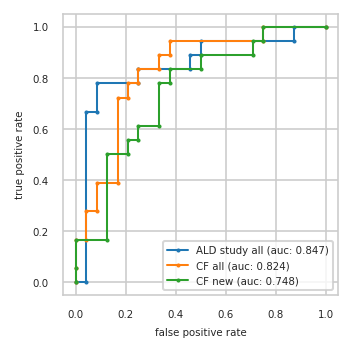

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       CF all       CF new      
             fpr   tpr    fpr   tpr    fpr   tpr
0          0.000 0.000  0.000 0.000  0.000 0.000
1          0.042 0.000  0.000 0.056  0.000 0.056
2          0.042 0.667  0.000 0.167  0.000 0.167
3          0.083 0.667  0.042 0.167  0.125 0.167
4          0.083 0.778  0.042 0.278  0.125 0.500
5          0.250 0.778  0.083 0.278  0.208 0.500
6          0.250 0.833  0.083 0.389  0.208 0.556
7          0.458 0.833  0.167 0.389  0.250 0.556
8          0.458 0.889  0.167 0.722  0.250 0.611
9          0.500 0.889  0.208 0.722  0.333 0.611
10         0.500 0.944  0.208 0.778  0.333 0.778
11         0.875 0.944  0.250 0.778  0.375 0.778
12         0.875 1.000  0.250 0.833  0.375 0.833
13         1.000 1.000  0.333 0.833  0.500 0.833
14           NaN   NaN  0.333 0.889  0.500 0.889
15           NaN   NaN  0.375 0.889  0.708 0.889
16           NaN   NaN  0.375 0.944  0.708 0.944
17           NaN   NaN  0.750 0.944  0.750 0.944
18           NaN   NaN  0.750 1.000  0.750 1.000
19           NaN   NaN  1.000 1.000  1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,CF all,CF new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,Q9NX62,A0A087WXB8;Q9Y274,Q16799
2,G3XAI2;P07942,P02741,E5RJY1;E7ESM1;Q92597;Q92597-2;Q92597-3
3,B1AHL2;P23142-4,F8WE04;P04792,P31321
4,P61981,Q9Y2T3;Q9Y2T3-3,P51688
5,P04075,P61981,A0A075B7B8
6,P14174,P04075,Q96GD0
7,Q9Y2T3;Q9Y2T3-3,P25189;P25189-2,Q9NUQ9
8,Q99983,P63104,A6PVN5;F6WIT2;Q15257;Q15257-2;Q15257-3


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve.pdf


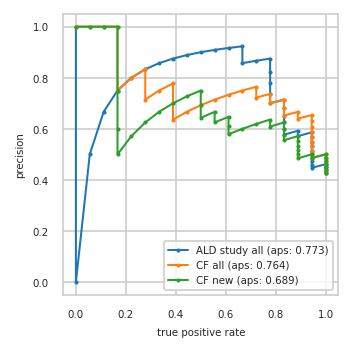

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all          CF all          CF new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.447 0.944     0.474 1.000     0.474 1.000
5          0.459 0.944     0.486 1.000     0.486 1.000
6          0.472 0.944     0.500 1.000     0.500 1.000
7          0.486 0.944     0.486 0.944     0.486 0.944
8          0.500 0.944     0.500 0.944     0.500 0.944
9          0.515 0.944     0.515 0.944     0.485 0.889
10         0.531 0.944     0.531 0.944     0.500 0.889
11         0.548 0.944     0.548 0.944     0.516 0.889
12         0.567 0.944     0.567 0.944     0.533 0.889
13         0.586 0.944     0.586 0.944     0.552 0.889
14         0.571 0.889     0.607 0.944     0.571 0.889
15         0.593 0.889     0.630 0.944     0.556 0.833
16         0.577 0.833     0.654 0.944     0.577 0.833
17         0.600 0.833     0.640 0.889     0.600 0.833
18         0.625 0.833     0.667 0.889     0.625 0.833
19         0.652 0.833     0.652 0.833     0.609 0.778
20         0.682 0.833     0.682 0.833     0.636 0.778
21         0.714 0.833     0.714 0.833     0.619 0.722
22         0.700 0.778     0.700 0.778     0.600 0.667
23         0.737 0.778     0.737 0.778     0.579 0.611
24         0.778 0.778     0.722 0.722     0.611 0.611
25         0.824 0.778     0.765 0.722     0.647 0.611
26         0.875 0.778     0.750 0.667     0.625 0.556
27         0.867 0.722     0.733 0.611     0.667 0.556
28         0.857 0.667     0.714 0.556     0.643 0.500
29         0.923 0.667     0.692 0.500     0.692 0.500
30         0.917 0.611     0.667 0.444     0.750 0.500
31         0.909 0.556     0.636 0.389     0.727 0.444
32         0.900 0.500     0.700 0.389     0.700 0.389
33         0.889 0.444     0.778 0.389     0.667 0.333
34         0.875 0.389     0.750 0.333     0.625 0.278
35         0.857 0.333     0.714 0.278     0.571 0.222
36         0.833 0.278     0.833 0.278     0.500 0.167
37         0.800 0.222     0.800 0.222     0.600 0.167
38         0.750 0.167     0.750 0.167     0.750 0.167
39         0.667 0.111     1.000 0.167     1.000 0.167
40         0.500 0.056     1.000 0.111     1.000 0.111
41         0.000 0.000     1.000 0.056     1.000 0.056
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve_train.pdf


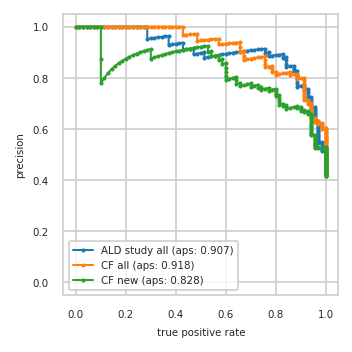

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve_train.pdf


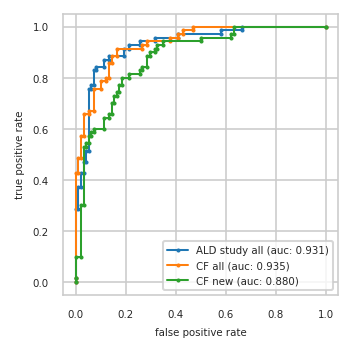

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_CF all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_CF all.pkl'),
 'results_CF new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_CF new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve_train.pdf')}